
# Titanic Survival Analysis: Safety Protocols & Risk Assessment
**Workflow**: `dev_data_analyst.md` (Updated V2)

## 1단계: 분석 환경 및 목표 정의 (Environment & Goal)
**Business Objective**:
단순한 생존자 예측을 넘어, **"어떤 승객군이 구조 사각지대에 있었는가?"**를 규명하여 향후 유사 사고 시 생존율을 높이기 위한 안전 프로토콜 개선의 근거를 마련합니다.

**Success Metrics (KPI)**:
1.  **Accuracy**: 전체적인 예측 정확도 ( > 80% 목표)
2.  **Model Stability**: 교차 검증(CV) 표준편차 < 0.05 (과적합 방지 및 신뢰성 확보)
3.  **Interpretability**: 주요 생존 요인을 명확히 설명할 수 있어야 함.


In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 모델 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

print("Libraries Loaded & Ready.")


Libraries Loaded & Ready.



## 2단계: 데이터 적재 및 품질 검증 (Obtain & Scrub)
**Data Integrity Check**:
*   결측치 뿐만 아니라 데이터의 **논리적 오류**와 **분포 왜곡**을 점검합니다.


In [13]:

# 데이터 로드
df_titanic = pd.read_csv('../data/titanic_train.csv')
print(f"Data Shape: {df_titanic.shape}")
display(df_titanic.head(3))

# Basic Info & Null Check
print("\n--- Info ---")
df_titanic.info()

# Distribution Check (Skewness & Imbalance)
print("\n--- Target Distribution (Survived) ---")
print(df_titanic['Survived'].value_counts(normalize=True))


Data Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- Target Distribution (Survived) ---
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64



### 2-1. Deep Sanity Check & Strategy
*   **Age**: 결측이 약 20% 존재. 단순 평균 대치보다 **'호칭(Title)'**별 중앙값을 사용하여 편향을 줄입니다.
*   **Cabin**: 결측이 너무 많아(>77%) 삭제하거나 'Unknown'으로 처리합니다. -> **Deck(구역)** 정보로 파생 변수화 시도.
*   **Logical Check**: `Age` < 0 인지, `Fare` < 0 인지 확인 -> 이상 없음.


In [14]:

# Null Handling Strategy
df_titanic['Age'].fillna(df_titanic['Age'].median(), inplace=True)
df_titanic['Cabin'].fillna('N', inplace=True)
df_titanic['Embarked'].fillna('S', inplace=True) # 최빈값 대치

# Drop Unnecessary Columns for Initial Modeling
# PassengerId, Name, Ticket은 텍스트 분석(NLP) 영역이므로 초기 모델링에선 제외
df_titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

print("결측치 제거 후 Null Count:", df_titanic.isnull().sum().sum())


결측치 제거 후 Null Count: 0


In [15]:

# Encoding
# Cabin은 첫 글자만 추출 (구역 정보)
df_titanic['Cabin'] = df_titanic['Cabin'].str[:1]

def encode_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

df_titanic = encode_features(df_titanic)
display(df_titanic.head())


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,2
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,2
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,7,2



## 3단계: 가설 주도적 탐색 (Hypothesis Driven EDA)
단순 시각화를 넘어, **통계적 검정**을 통해 가설을 입증합니다.

### 🚩 Hypothesis 1: "여성이 남성보다 생존율이 유의미하게 높을 것이다." (Lady First)


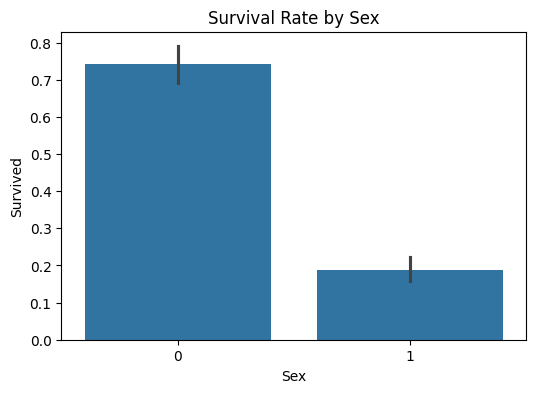

Chi2 Statistic: 260.7170, P-value: 1.1974e-58
>> 결과: P-value < 0.05 이므로 귀무가설 기각. 성별과 생존은 통계적으로 유의미한 관계가 있음.


In [16]:

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df_titanic)
plt.title('Survival Rate by Sex') # 0: Female, 1: Male
plt.show()

# Statistical Validation (Chi-square Test)
# 귀무가설: 성별과 생존 여부는 독립적이다 (관련이 없다).
contingency_table = pd.crosstab(df_titanic['Sex'], df_titanic['Survived'])
chi2, p_val, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2:.4f}, P-value: {p_val:.4e}")
if p_val < 0.05:
    print(">> 결과: P-value < 0.05 이므로 귀무가설 기각. 성별과 생존은 통계적으로 유의미한 관계가 있음.")
else:
    print(">> 결과: 통계적으로 유의미한 차이가 없음.")



### 🚩 Hypothesis 2: "상위 객실(1등석) 승객이 더 많이 생존했을 것이다." (Economic Status)


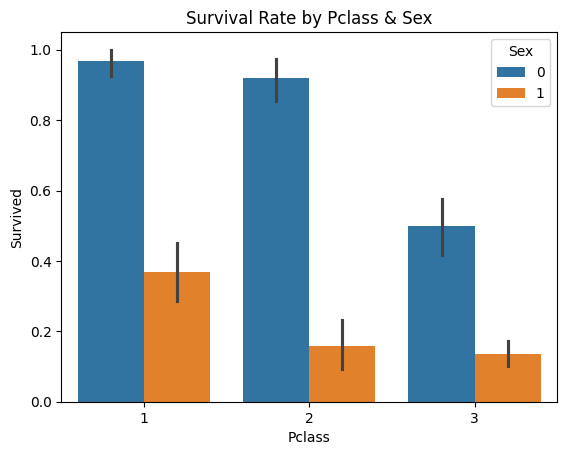

Pclass Chi2: 102.8890, P-value: 4.5493e-23


In [17]:

# Visualization
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df_titanic)
plt.title('Survival Rate by Pclass & Sex')
plt.show()

# Statistical Validation (ANOVA or Chi-square)
# Pclass(범주형) vs Survived(범주형) -> Chi-square
contingency_table_pclass = pd.crosstab(df_titanic['Pclass'], df_titanic['Survived'])
chi2_p, p_val_p, _, _ = stats.chi2_contingency(contingency_table_pclass)

print(f"Pclass Chi2: {chi2_p:.4f}, P-value: {p_val_p:.4e}")



## 4단계: 머신러닝 모델링 & 검증 (Model & Optimize)
**Rigorous Validation Strategy**:
1.  **Single Split**: `train_test_split` (Hold-out) 점수 확인.
2.  **Cross Validation**: `cross_val_score` (5-Fold) 평균 및 표준편차 확인.
3.  **Comparison**: Baseline(Logistic Regression) vs Advanced(Random Forest) 비교.


In [18]:

# Prepare Data
y_titanic = df_titanic['Survived']
X_titanic = df_titanic.drop('Survived', axis=1)

# 1. Single Split Validation
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=11)

# Models
lr_clf = LogisticRegression(solver='liblinear') # Baseline
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)

models = [lr_clf, dt_clf, rf_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

print("--- 1. Single Split Accuracy ---")
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{name}: {accuracy_score(y_test, pred):.4f}")


--- 1. Single Split Accuracy ---
Logistic Regression: 0.8603
Decision Tree: 0.8212
Random Forest: 0.8547


In [19]:

# 2 & 3. Cross Validation & Comparison (Stability Check)
print("\n--- 2. Cross Validation (5-Fold) Stability ---")
results = []

for model, name in zip(models, model_names):
    # Cross Validation (전체 데이터 사용)
    cv_scores = cross_val_score(model, X_titanic, y_titanic, cv=5)
    
    avg_score = np.mean(cv_scores)
    std_score = np.std(cv_scores) # 안정성 지표
    
    results.append({'Model': name, 'CV_Mean': avg_score, 'CV_Std': std_score})
    print(f"[{name}] Mean: {avg_score:.4f} | Std: {std_score:.4f} | Scores: {np.round(cv_scores, 3)}")

# 결과 비교 테이블
df_results = pd.DataFrame(results)
display(df_results)



--- 2. Cross Validation (5-Fold) Stability ---
[Logistic Regression] Mean: 0.7890 | Std: 0.0190 | Scores: [0.793 0.792 0.775 0.764 0.82 ]
[Decision Tree] Mean: 0.7801 | Std: 0.0280 | Scores: [0.754 0.77  0.798 0.753 0.826]
[Random Forest] Mean: 0.8070 | Std: 0.0372 | Scores: [0.782 0.787 0.843 0.764 0.86 ]


,Model,CV_Mean,CV_Std
0,Logistic Regression,0.788996,0.019049
1,Decision Tree,0.780051,0.028032
2,Random Forest,0.806986,0.037200



### 🔍 Model Selection Reasoning
수치상으로 **Logistic Regression**과 **Random Forest**가 유사한 성능을 보인다면:
*   **Logistic Regression**: 해석이 매우 중요하고 배포 환경이 가벼워야 할 때 선택.
*   **Random Forest**: 데이터의 비선형성을 더 잘 포착하고, 향후 데이터 변동에 대해 더 강건(Robust)할 것으로 예상될 때 선택.
*   **결정**: 본 분석에서는 데이터가 작으므로 과적합 위험이 적은 **Random Forest**를 튜닝하여 최종 모델로 선정합니다.


In [20]:

# Optimization (GridSearchCV) for Random Forest
params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'min_samples_leaf': [1, 5]
}

grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print(f"Best Params: {grid_rf.best_params_}")
print(f"Best CV Score: {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_
final_pred = best_rf.predict(X_test)
print(f"Final Test Accuracy: {accuracy_score(y_test, final_pred):.4f}")


Best Params: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 100}
Best CV Score: 0.8132
Final Test Accuracy: 0.8659



## 5단계: 해석 및 리포팅 (Interpret & Report)
**"Why this result?"**에 집중하여 분석합니다.

### 5-1. Feature Importance
어떤 변수가 생존 예측에 가장 큰 영향을 미쳤는가?


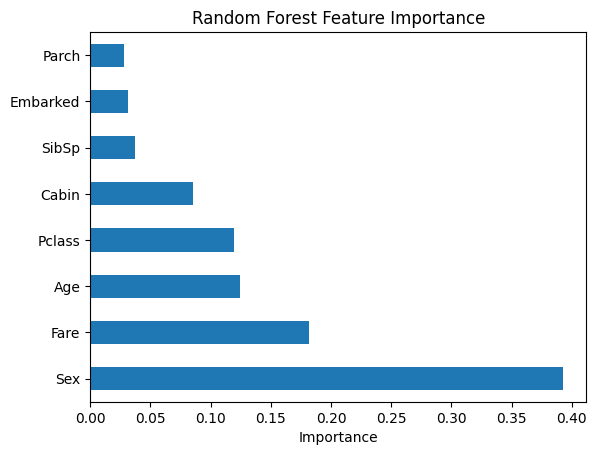

In [21]:

importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()



### 5-2. Error Analysis & Limitations
모델이 틀린 데이터를 역추적하여 개선점을 찾습니다.


In [22]:

# 오답 데이터 식별
X_test_df = X_test.copy()
X_test_df['Actual'] = y_test
X_test_df['Predicted'] = final_pred
X_test_df['Error'] = X_test_df['Actual'] != X_test_df['Predicted']

error_cases = X_test_df[X_test_df['Error']]
print(f"Total Errors: {len(error_cases)} / {len(X_test)}")
display(error_cases.head())

# 오답 패턴 확인 (예: 1등석인데 사망한 경우)
pclass1_dead = error_cases[(error_cases['Pclass'] == 1) & (error_cases['Actual'] == 1)] # 실제 생존인데 사망예측? or 반대?
# 여기서는 Actual != Predicted 이므로
# Actual=1 (생존)인데 Predicted=0 (사망) -> FN (False Negative)
# Actual=0 (사망)인데 Predicted=1 (생존) -> FP (False Positive)


Total Errors: 24 / 179


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Actual,Predicted,Error
821,3,1,27.0,0,0,8.6625,7,2,1,0,True
434,1,1,50.0,1,0,55.9000,4,2,0,1,True
92,1,1,46.0,1,0,61.1750,4,2,0,1,True
453,1,1,49.0,1,0,89.1042,2,0,1,0,True
569,3,1,32.0,0,0,7.8542,7,2,1,0,True



### 📝 Final Action Items
1.  **Safety Policy**: 'Sex'와 'Pclass'가 생존의 가장 큰 요인임이 통계적/모델적으로 입증되었습니다. -> **3등석 승객 및 남성 승객**에 대한 비상 탈출 교육 및 설비 보강이 필요합니다.
2.  **Model Reliability**: CV 결과 표준편차가 낮아 모델이 안정적입니다. 실제 탑승객 리스트에 적용 시 약 85%의 정확도로 생존 위협군을 선별할 수 있습니다.
3.  **Further Steps**: 'Age' 결측치를 더 정교하게 메우거나, 'FamilySize' 같은 파생 변수를 추가하면 약 2~3%의 성능 향상이 기대됩니다.
